# Layer-wise Relevance Propagation using Abstract Semiring elements for the MNIST Dataset

In [115]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import ProvLRP
import ProvLRP_config
from importlib import reload
reload(ProvLRP)

<module 'ProvLRP' from '/Users/antoinegroudiev/Documents/Travail/L3-Internship/code/ProvLRP.py'>

## 0. Load datset

In [43]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [44]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [45]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1. Train simple model

In [46]:
device = torch.device('mps')

In [47]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [48]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1#3

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [49]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(inputs, hidden1),
    nn.ReLU(),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [50]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 0.35457 | Test loss: 0.14672, Test acc: 95.43%


## 2. Layer-wise Relevance Propagation

In [51]:
semiring = ProvLRP.Semiring

### 2.0 Preparing for LRP

In [52]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [53]:
SUBSET = 20

X = train.data.reshape((60000, 784)).detach().numpy()
X = X[:SUBSET]
T = train.targets.detach().numpy()
T = T[:SUBSET]

In [54]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

### 2.1 Using $z^\mathcal{B}$

In [55]:
nb_digits = len(train.classes)
R = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

General rule for the hidden and output layers:
$$
R^{(l)}_j = \bigoplus_k \Theta_a(a^{(l)}_j) \otimes\Theta_w(w^{(l)}_{jk}) \otimes R^{(l+1)}_k
$$

In [56]:
def rho(w, l):  return w

Four steps of computing the relevance:
$$
\begin{align*}
\forall k:~s_k &= \Theta_R(R_k) \qquad & (\text{step }1)\\
\forall j:~c_j &= \bigoplus_k \rho(\Theta_w(w_{jk})) \otimes s_k \qquad & (\text{step }2)\\
\forall j:~R_j &= \Theta_A(a_j) \otimes c_j \qquad & (\text{step }3)
\end{align*}
$$

In [57]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)
    #b = rho(B[l], l)

    #z = incr(A[l].dot(w)+b, l)
    s = R[l+1] #/ z
    c = s.dot(w.T)
    R[l] = semiring.from_activation(A[l]) * c

$z^\mathcal{B}$ rule for the input layer:
$$R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j$$

In [58]:
w = semiring.from_weight(W[0])
wp = semiring.vect_pos(w)
wm = semiring.vect_neg(w)
lb = semiring.lower_bound(A[0].shape, -1)
hb = semiring.upper_bound(A[0].shape, 1)

s = R[1]
c = s @ w.T
cp = s @ (wp.T)
cm = s @ (wm.T)
R[0] = semiring.from_activation(A[0])*c - lb*cp - hb*cm

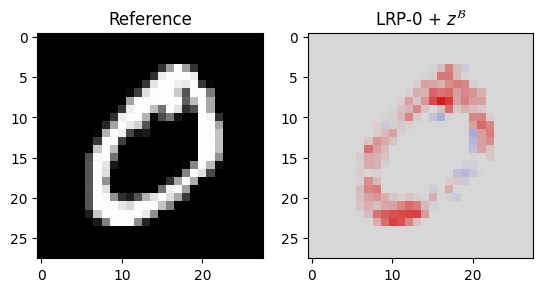

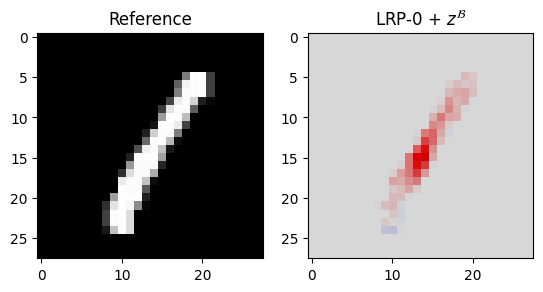

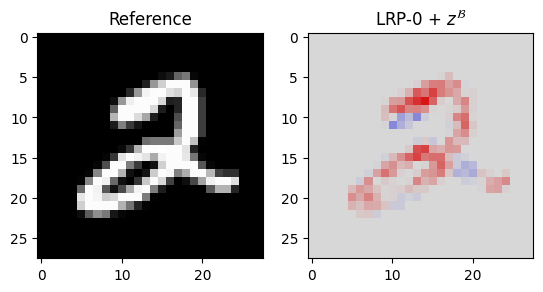

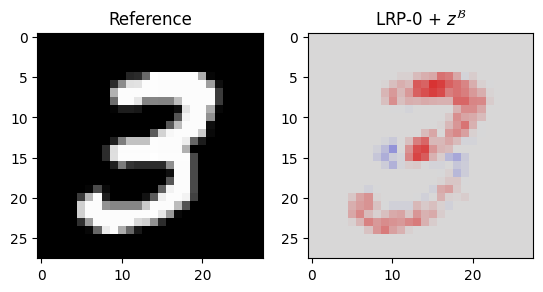

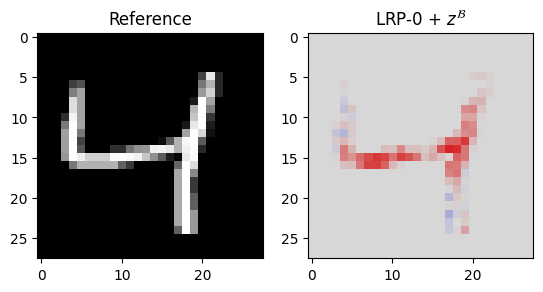

In [59]:
Rf = [semiring.semiring_to_float(x) for x in R]

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    axs[1].set_title("LRP-0 + $z^\\mathcal{B}$")
    plt.show()

#### 2.2 Without $z^\mathcal{B}$
Computations:

In [60]:
R_wozB = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_wozB[l+1]
    c = s.dot(w.T)
    R_wozB[l] = semiring.from_activation(A[l]) * c

Visualization:

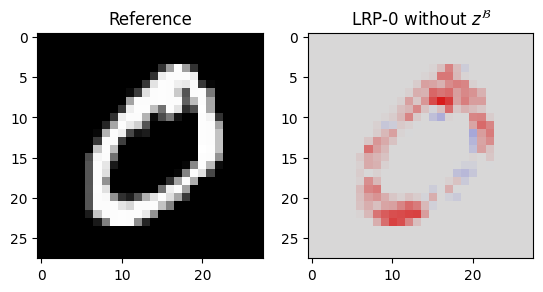

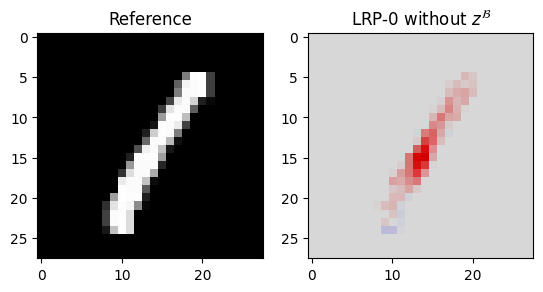

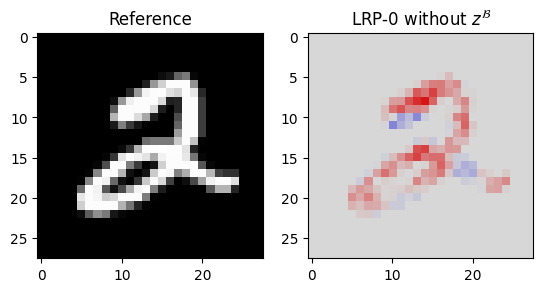

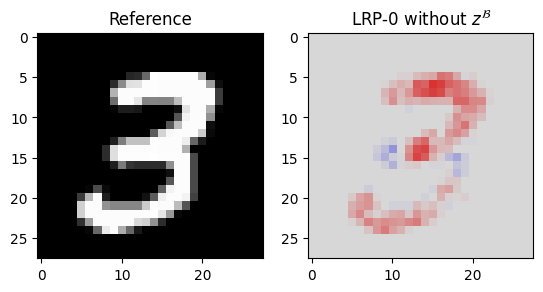

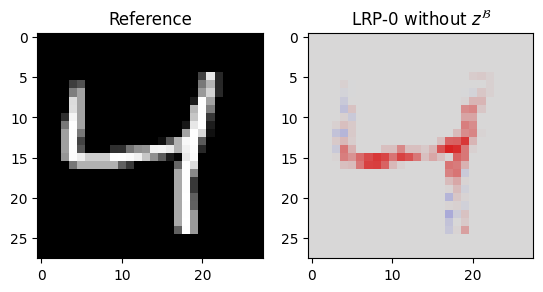

In [61]:
Rf = [semiring.semiring_to_float(x) for x in R_wozB]

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    b = 10*(np.abs(image)**3.0).mean()**(1.0/3)

    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")
    axs[1].imshow(image,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    axs[1].set_title("LRP-0 without $z^\\mathcal{B}$")
    plt.show()

## 3. Exploring different semirings
### 3.1 Boolean semiring

In [155]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5

ProvLRP_config.boolean_activation_threshold = 1.
ProvLRP_config.boolean_weight_threshold = 1.

R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

# All layers, even the pixels one
for l in range(0, L)[::-1]:
    w = rho(semiring.from_weight(W[l]), l)

    s = R_bool[l+1]
    c = s.dot(w.T)
    R_bool[l] = semiring.from_activation(A[l]) * c

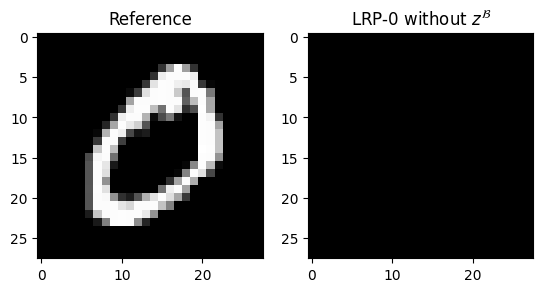

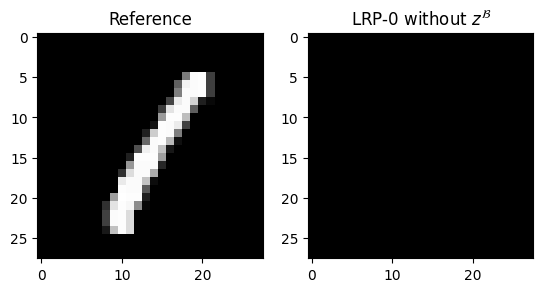

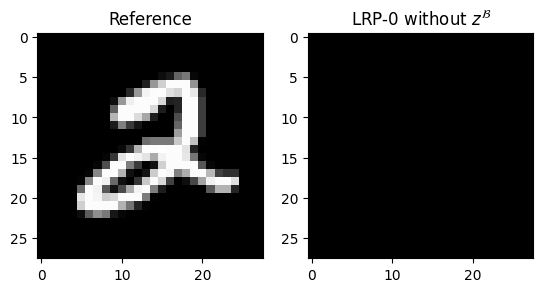

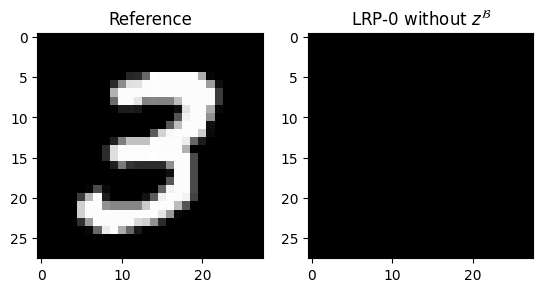

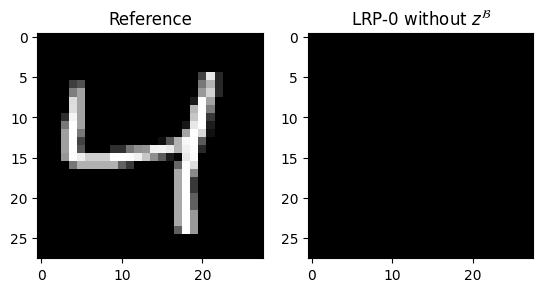

In [156]:
Rf = [semiring.semiring_to_float(x) for x in R_bool]

DIGITS = 5
for i in range(DIGITS):
    image = Rf[0][T==i][0].reshape((28, 28))

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(X[T==i][0].reshape((28, 28)), cmap="gray")
    axs[0].set_title("Reference")

    axs[1].imshow(image, cmap="gray", vmin=0, vmax=1)
    axs[1].set_title("LRP-0 without $z^\\mathcal{B}$")

    plt.show()

#### Influence of the thresholds

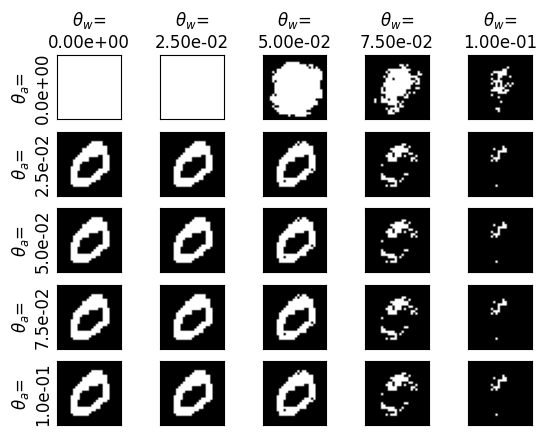

In [169]:
reload(ProvLRP)
reload(ProvLRP_config)
semiring = ProvLRP.BooleanSemiring

ProvLRP_config.boolean_relevance_threshold = 0.5
activation_thresholds = np.linspace(0, 0.1, 5)
weight_thresholds = np.linspace(0, 0.1, 5)

fig, axs = plt.subplots(len(activation_thresholds), len(weight_thresholds))

for ax, i in zip(axs[0], range(len(weight_thresholds))):
    ax.set_title(f"$\\theta_w$=\n{weight_thresholds[i]:0.2e}")

for ax, j in zip(axs[:,0], range(len(activation_thresholds))):
    ax.set_ylabel(f"$\\theta_a$=\n{activation_thresholds[j]:0.1e}", size='large')

for i, theta_a in enumerate(activation_thresholds):
    for j, theta_w in enumerate(weight_thresholds):
        ProvLRP_config.boolean_activation_threshold = theta_a
        ProvLRP_config.boolean_weight_threshold = theta_w
        
        R_bool = [None] * L + [semiring.from_relevance(A[L] * (T[:,None]==np.arange(nb_digits)))]

        # All layers, even the pixels one
        for l in range(0, L)[::-1]:
            w = rho(semiring.from_weight(W[l]), l)

            s = R_bool[l+1]
            c = s.dot(w.T)
            R_bool[l] = semiring.from_activation(A[l]) * c

        Rf = [semiring.semiring_to_float(x) for x in R_bool]
        image = Rf[0][T==0][0].reshape((28, 28))

        axs[i][j].imshow(image, cmap="gray", vmin=0, vmax=1)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

plt.show()